In [1]:
import lxml.etree
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
#!pip install spacy
import spacy
from tqdm import tqdm
from scipy.stats import kendalltau
import os 
plt.style.use('ggplot')
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.chdir('C:/Users/Dora Sperling/Desktop/Thesis/')

In [13]:
def clean_text(
    string: str, 
    punctuation=r'''!()[]{};:-'"‘’“”\,<>.…/?@#$%^&*_~''') -> str:
    '''
    Takes a string, removes punctuation, and lowercases.
    Returns a string. 
    '''
    # Removing the punctuation
    for x in string.lower(): 
        if x in punctuation: 
            string = string.replace(x, "") 
    string = re.sub('—', ' ', string)
    # Converting the text to lower
    string = string.lower()
    string = ' '.join([word for word in string.split()])
    # Cleaning the whitespaces
    string = re.sub(r'\s+', ' ', string).strip()
    return string

In [14]:
metadata_df = pd.read_csv('pratchett_metadata.csv')
# Only look at adult novels
metadata_df = metadata_df[metadata_df.YA == False].reset_index(drop=True)
metadata_df.head()

,title,year_of_publication,age_at_publication,YA,number_of_words,text,untokenized_text
0,The Color Of Magic,1983,35.58,False,66492,in a distant and secondhand set of dimensions ...,"In A distant and secondhand set of dimensions,..."
1,The Light Fantastic,1986,38.10,False,45998,the sun rose slowly as if it was nt sure it wa...,"The sun rose slowly, as if it wasn’t sure it w..."
2,Equal Rites,1987,38.72,False,67372,this is a story about magic and where it goes ...,This is a story about magic and where it goes ...
3,Mort,1987,39.51,False,73987,this is the bright candlelit room where the li...,This is the bright candlelit room where the li...
4,Sourcery,1988,40.08,False,79536,there was a man and he had eight sons apart fr...,There was a man and he had eight sons. Apart f...


In [31]:
metadata_df.text[0][0:200]

'in a distant and secondhand set of dimensions in an astral plane that was never meant to fly the curling star mists waver and part see great atuin the turtle comes swimming slowly through the interste'

# 1. Type-token ratios - 5000-token segments

In [15]:
# Define necessary functions

def get_chunks(text, n):
    '''
    Takes a string and an integer.
    Divides a string into non-overlapping segments of token length n. 
    Returns a list of the segments. 
    '''
    tokenlist = text.split()
    chunks = []
    for i in range(0, len(tokenlist), n):
        if len(tokenlist[i:i + n]) == n: # do not include trailing words after the the last whole segment
            chunks.append(" ".join(tokenlist[i:i + n]))
    return chunks

def mean_std_ttr(cleantext, windowsize):
    """
    Calculates the type-token ratio of all text segments. 
    Returns the mean and standard deviation of the type-token ratios. 
    """
    chunks = get_chunks(cleantext, windowsize)
    TT_ratios = []
    for chunk in chunks:
        types = Counter(chunk.split())
        TT_ratios.append(len(types)/windowsize)
    return np.mean(TT_ratios), np.std(TT_ratios)



# Calculate mean TTR and the standard deviation in TTR per book 
mean_ttr_5000tok = []
std_ttr_5000tok = []

for cleaned_text in metadata_df.text:
    mean_ttr, std_ttr = mean_std_ttr(cleaned_text, 5000)
    mean_ttr_5000tok.append(mean_ttr)
    std_ttr_5000tok.append(std_ttr)

## 1a. Test assumption that TTR does not increase/decrease significantly over course of book

In [19]:
# Store books where a segment's type-token ratio varies significantly with the segment's place in the book

# Tests possibility that type-token ratio might be higher in beginning of book when concepts/characters are
# still being introduced to readers


problematic_books = []
for i in range(metadata_df.shape[0]):
    chunks = get_chunks(metadata_df.loc[i, 'text'], 5000)
    
    TT_ratios = []
    for chunk in chunks:
        types = Counter(chunk.split())
        TT_ratios.append(len(types)/5000)
    
    # Get the number of indexes in the list storing type-token ratios from a single book
    num_indices = len(TT_ratios)
    
    # Get the Kendall's tau correlation between the segment locations/indexes and the type-token ratios
    tau_results = kendalltau(range(num_indices), TT_ratios)
    
    # If the Kendall's tau correlation is significant, print the book title and correlation
    if tau_results[1] <= 0.05:
        print("TTRs vary significantly with place in text: " + metadata_df.loc[i, 'title'])
        print("\tKendall's tau: " + str(tau_results[0]))
        
        # Store books with a significant correlation between segment location and segment type-token ratio
        problematic_books.append(metadata_df.loc[i, 'title'])

TTRs vary significantly with place in text: The Light Fantastic
	Kendall's tau: -0.7222222222222222
TTRs vary significantly with place in text: Sourcery
	Kendall's tau: -0.5428571428571429
TTRs vary significantly with place in text: Small Gods
	Kendall's tau: -0.3856209150326798
TTRs vary significantly with place in text: Men at Arms
	Kendall's tau: -0.391812865497076
TTRs vary significantly with place in text: Soul Music
	Kendall's tau: -0.32844716010296715
TTRs vary significantly with place in text: Interesting Times
	Kendall's tau: -0.4379084967320262
TTRs vary significantly with place in text: Feet of Clay
	Kendall's tau: -0.4152046783625731
TTRs vary significantly with place in text: Hogfather
	Kendall's tau: -0.3684210526315789
TTRs vary significantly with place in text: Jingo
	Kendall's tau: -0.39047619047619053
TTRs vary significantly with place in text: The Truth
	Kendall's tau: -0.5966604105161744
TTRs vary significantly with place in text: Thief of Time
	Kendall's tau: -0.37

In [24]:
# Make a list of booleans to store info about whether type-token ratio varied signficantly in a book or not


TTR_sig_internal_variation = [True if title in problematic_books else False for title in metadata_df.title ]
print(len(TTR_sig_internal_variation))
TTR_sig_internal_variation[0:5]

35


[False, True, False, False, True]

## 1b. Mark books where vocabulary metric varies significantly with place in book

Text(0.5, 0, 'Age at publication (years)')

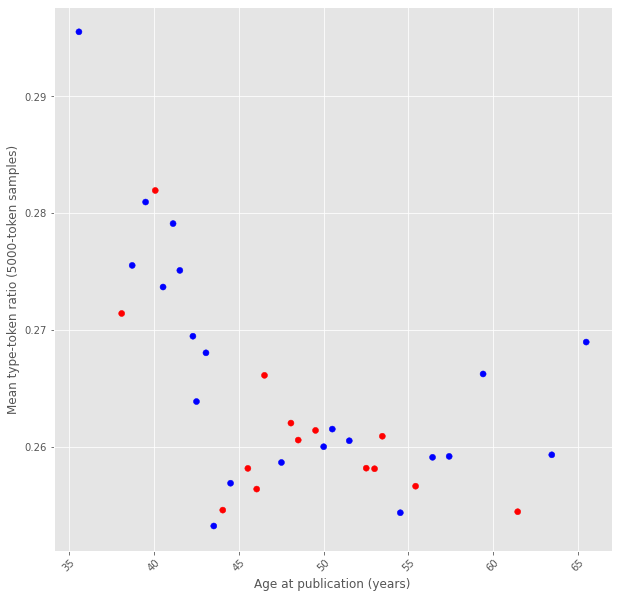

In [25]:
col =[]
  
# Blue books have no significant internal variation in type-token ratio
# Red books do

for title in metadata_df.title:
    if title not in problematic_books:
        col.append('blue')  
    else:
        col.append('red')
        
f, ax = plt.subplots(figsize=(10,10))

ax.scatter(metadata_df.age_at_publication, mean_ttr_5000tok, c=col)


plt.xticks(rotation=45);
ax.set_ylabel('Mean type-token ratio (5000-token samples)')
ax.set_xlabel('Age at publication (years)')

# 2. Indefinite Words - Full Texts

In [26]:
# Calculate counts of tokens 'stuff', 'anything', 'something', 'thing', and 'things' from full texts (not segments)

indefinite_wordcounts = []
for text in metadata_df.text:

    count_dict = Counter(text.split())

    stuffcount = count_dict['stuff']
    anythingcount = count_dict['anything']
    thingcount = count_dict['thing'] + count_dict['things']
    somethingcount = count_dict['something']

    indefinite_wordcount = stuffcount + anythingcount + thingcount + somethingcount

    indefinite_wordcounts.append(indefinite_wordcount/len(text.split()))

Text(0.5, 0, 'Age at publication (years)')

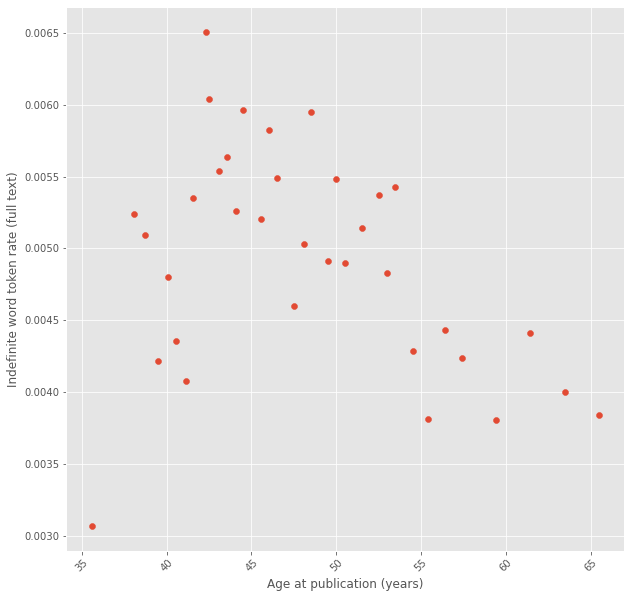

In [27]:
f, ax = plt.subplots(figsize=(10,10))

ax.scatter(metadata_df.age_at_publication, indefinite_wordcounts)

plt.xticks(rotation=45);
ax.set_ylabel('Indefinite word token rate (full text)')
ax.set_xlabel('Age at publication (years)')

# 3. Phrase repetition in 5000-token segments

In [38]:
from sklearn.feature_extraction.text import CountVectorizer 

In [39]:
# Steal code from Professor Daelemans

def count_unique_repetitions(text):
    '''
    Takes a string, divides it into ngrams of length 2 to 4 and throws out ngrams that only appear once.
    Returns a count of how many unique repeated 2-4-grams are in the string.
    '''
    vect = CountVectorizer(ngram_range=(2,4))
    analyzer = vect.build_analyzer()
    fdict = Counter(analyzer(text))
    fdict = {k:v for (k,v) in fdict.items() if v > 1}
    strings = fdict.keys()
    
    # remove the strings that occur only inside another string
    result = list(strings)
    for s1 in strings:
        fs1 = fdict[s1]
        for s2 in strings:
            if s1 < s2 and s1 in s2:
                fs2 = fdict[s2]
                if fs1 <= fs2:
                    result.remove(s1)
                    break
    return len(result)

In [40]:
def mean_std_reps_perchunk(cleantext, windowsize):
    '''
    Takes a text, a segment length, and a list of words to search for.
    Returns average of the rates at which words in the list appear, for every segment, and the standard deviation. 
    '''
    chunks = get_chunks(cleantext, windowsize)
    num_unique_repeated_phrases = []
    
    for chunk in chunks:
        n_unique = count_unique_repetitions(chunk)
        num_unique_repeated_phrases.append(n_unique/windowsize)
        
    return np.mean(num_unique_repeated_phrases), np.std(num_unique_repeated_phrases)

In [41]:
mean_std_reps_perchunk(metadata_df.loc[0,'text'], 5000)

(0.08064615384615384, 0.00587152389924526)

In [42]:
mean_reps_5000tok = []
std_reps_5000tok = []

for text in metadata_df.text:
    mean_n_unique_reps, std_n_unique_reps = mean_std_reps_perchunk(text, 5000)
    mean_reps_5000tok.append(mean_n_unique_reps)
    std_reps_5000tok.append(std_n_unique_reps)

## 3a. Test assumption that rates of repetitions does not increase/decrease significantly over course of book

In [43]:
# Store books where a segment's repetition rate varies significantly with the segment's place in the book

# Tests possibility that repetition might be higher at the end of book when concepts/characters are no longer
# being introduced to readers

problematic_books = []

for i in range(metadata_df.shape[0]):
    chunks = get_chunks(metadata_df.loc[i, 'text'], 5000)
    num_unique_repeated_phrases = []

    for chunk in chunks:
        n_unique = count_unique_repetitions(chunk)
        num_unique_repeated_phrases.append(n_unique/5000)
    
    # Get the number of indexes in the list storing repetition rates from a single book
    num_indices = len(num_unique_repeated_phrases)
    
    # Get the Kendall's tau correlation between the segment locations/indexes and the number of repeated phrases
    tau_results = kendalltau(range(num_indices), num_unique_repeated_phrases)
    
    # If the Kendall's tau correlation is significant, print the book title and correlation
    if tau_results[1] <= 0.05:
        print("Repetition rates vary significantly with place in text: " + metadata_df.loc[i, 'title'])
        print("\tKendall's tau: " + str(tau_results[0]))
        
        # Store books with a significant correlation between segment location and segment repetition rate
        problematic_books.append(metadata_df.loc[i, 'title'])

Repetition rates vary significantly with place in text: The Light Fantastic
	Kendall's tau: 0.7222222222222222
Repetition rates vary significantly with place in text: Wyrd Sisters
	Kendall's tau: 0.40590682253921034
Repetition rates vary significantly with place in text: Men at Arms
	Kendall's tau: 0.3401774158209303
Repetition rates vary significantly with place in text: The Fifth Elephant
	Kendall's tau: 0.4726759937885687
Repetition rates vary significantly with place in text: The Truth
	Kendall's tau: 0.3636405261167026
Repetition rates vary significantly with place in text: Unseen Academicals
	Kendall's tau: 0.4828591137146904


In [45]:
# Make a list of booleans to store info about whether repetition rate varied signficantly in a book or not

rep_sig_internal_variation = [True if title in problematic_books else False for title in metadata_df.title]
print(len(rep_sig_internal_variation))
print(rep_sig_internal_variation[0:5])

35
[False, True, False, False, False]


## 3b. Mark books where vocabulary metric varies significantly with place in book

Text(0.5, 0, 'Age at publication (years)')

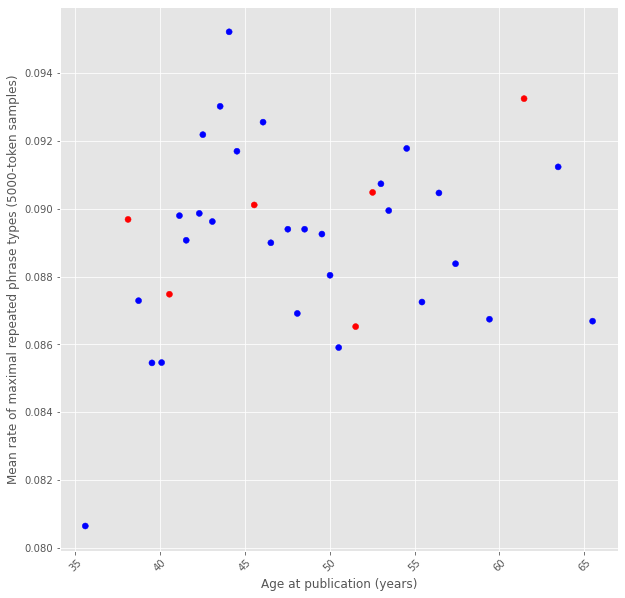

In [47]:
col =[]
  
# Blue books have no significant internal variation in repetition rate
# Red books do    

for title in metadata_df.title:
    if title not in problematic_books:
        col.append('blue')  
    else:
        col.append('red')
        
f, ax = plt.subplots(figsize=(10,10))

ax.scatter(metadata_df.age_at_publication, mean_reps_5000tok, c=col)


plt.xticks(rotation=45);
ax.set_ylabel('Mean rate of maximal repeated phrase types (5000-token samples)')
ax.set_xlabel('Age at publication (years)')

# 4. Save dataframe for significance testing

In [114]:
metadata_df['mean_ttr_5000token_samples'] = mean_ttr_5000tok
metadata_df['TTR_sig_inbook_variation'] = TTR_sig_internal_variation

metadata_df['indefinite_word_rate'] = indefinite_wordcounts

metadata_df['mean_max_repphrasetype_5000token_samples'] = mean_reps_5000tok
metadata_df['rep_sig_inbook_variation'] = rep_sig_internal_variation

In [115]:
notext = metadata_df.drop(['text'], axis=1)

In [116]:
os.chdir('C:/Users/Dora Sperling/Desktop/Thesis')
notext.to_csv('1-vocabulary_richness.csv', encoding='utf8', index=False)

# (Could be useful - count total number of repeated phrases)

In [25]:
# chunks = get_chunks(metadata_df.loc[43,'text'], 2000)
# chunks[0][:100]

In [26]:
# chunks = get_chunks(metadata_df.loc[0,'text'], 2000)

In [27]:
# text = "I went home. I went to the grocery store. I went home. I was tired because I went to the grocery store. Because I was tired and I went to bed. I slept when I went to bed"

In [28]:
# text

In [29]:
# from collections import Counter

# def ngrams_locations(text, ngram_lengths = (2,5)):
#     '''
#     Takes a string and records n-grams (where n is 2, 3, and 4 - not 5). Returns a dictionary of n-grams that appear more than once.
#     The keys of the dictionary are the n-grams.
#     The values of the dictionary are lists containing all the indices where the n-grams occur. 
#     '''
#     listof_ngram_dicts = []
#     text = clean_text(text)
#     tokenlist = text.lower().split()
    
#     # Loop indefinitely
#     for ngram_range in range(ngram_lengths[0], ngram_lengths[1]):
        
#         # Initialize a new dictionary to store the ngrams that are found and the indexes where they're located
#         ngram_dict = {}
        
#         # Get a list of all ngrams by sliding a window over the text
#         ngramlist = [tokenlist[i:i+ngram_range] for i in range(len(tokenlist)) if i+ngram_range-1 < len(tokenlist)]
        
#         # Return all the unique ngrams in the text
#         unique_ngrams = Counter([tuple(ngram) for ngram in ngramlist])
        
#         # Loop through the unique ngrams that were found
#         for ngram in unique_ngrams:
#             positions = []
            
#             # Loop through the length of the text
#             for i in range(len(tokenlist)):
                
#                 # If a group of words matches the ngram, ...
#                 if ngram == tuple(tokenlist[i:i+ngram_range]):
                    
#                     # ... then record the indexes of all the words in the ngram, (i.e. where it's located)
#                     positions.append([inx for inx in range(i,i+ngram_range)])
#             # Make an entry in the ngram dictionary with the ngram as the key, and a list of lists of indices where it's located
#             ngram_dict[ngram] = positions
        
#         # Use a dictionary comprehension to filter out ngrams that only appear once (i.e. are not repeated)
#         ngram_dict = {" ".join(ngram):positions for ngram, positions in ngram_dict.items() if len(positions) >1}
        
        
#         # If the dictionary of repeated ngrams is empty after a certain ngram length, then stop the loop
#         if len(ngram_dict) == 0:
#             break
            
#         # If the dictionary still has repeated phrases 
#         else: 
#         # Append this dictionary to a list containing dictionaries of all the ngram lengths
#             listof_ngram_dicts.append(ngram_dict)
            
#         ngram_range += 1
    
#     return listof_ngram_dicts

In [30]:
# ngrams_locations(text)

In [31]:
# def remove_doublecounts(list_of_dicts):
#     largest_unique_repeated_phrases = []
    
#     # Initialize the count of the largest repeated ngrams at 0
#     count = 0
    
#     # loop over the list of dictionaries containing ngrams and their spans in the text
#     for i in range(len(list_of_dicts)):
        
#         # Compare contiguous pairs of ngram dictionaries, i.e. compare the 3gram dictionary to the 4gram dictionary, etc.
#         if i < len(list_of_dicts)-1:
#             ngram_dict = list_of_dicts[i]
#             next_ngram_dict = list_of_dicts[i+1]
            
#             # loop through all ngrams and the list of index spans (also a list)
#             for ngram, indices in ngram_dict.items():
                
#                 # Make a flat list containing all the indices in the spans of all recorded ngrams
#                 flat_inx_list = [inx for inxlists in next_ngram_dict.values() for inxlist in inxlists for inx in inxlist]
                
#     # If an ngram span in the dictionary of smaller ngrams does not appear in flat list of all indices of larger ngrams,...  
#                 for index_span in indices:
            
#                     if not set(index_span).issubset(flat_inx_list):
#                         largest_unique_repeated_phrases.append(ngram)
#     # ... then that ngram does not appear in a larger repeated ngram
#     # it is the longest repeated ngram and doesn't appear in a larger ngram
#     # Add 1 to the maximal repeated phrase count
#                         count +=1 
#         else:
#             ngram_dict = list_of_dicts[-1]
#             for key, value in ngram_dict.items():
#                 largest_unique_repeated_phrases.append(key)
#                 count += len(value)
#     return count


# def maximal_repeated_phrase_count(text, window_size):
#     repeated_phrase_rates = []
#     chunks = get_chunks(text, window_size)
#     for chunk in chunks:
#         list_of_dicts = ngrams_locations(chunk)
#         n_repeated_phrases = remove_doublecounts(list_of_dicts)
#         repeated_phrase_rates.append(n_repeated_phrases/window_size)
#     return np.mean(repeated_phrase_rates)

In [32]:
# print(text)
# # I went to the grocery store - 2
# # I was tired - 2
# # I went to bed - 2
# # I went home - 2

In [33]:
# list_of_dicts_text = ngrams_locations(text)
# remove_doublecounts(list_of_dicts_text)

In [34]:
# metadata_df.loc[0,'text']
# maximal_repeated_phrase_count(metadata_df.loc[0,'text'], 2000)

In [35]:
# mean_repeatphrase_rate = []
# for book in tqdm(metadata_df.text):
#     repeated_phraserate = maximal_repeated_phrase_count(book, 2000)
#     mean_repeatphrase_rate.append(repeated_phraserate)

In [36]:
# print(mean_repeatphrase_rate)

In [37]:
# f, ax = plt.subplots(figsize=(10,10))

# ax.scatter(metadata_df.age_at_publication, mean_repeatphrase_rate,
#            c=metadata_df['YA'].map(colors))

# plt.xticks(rotation=45);
# ax.legend()
# ax.set_ylabel('Repeated phrase rate (per 2000 tokens)')
# plt.axvspan(57, 67, color='red', alpha=0.2)
# ax.set_xlabel('Age at Publication')